### What this notebook cell does

**Goal:**  
This cell measures how well our 2D keypoint tracker (SLEAP) is doing across time and across cameras.  
We ask:  
- For each face/jaw landmark node: how often is it detected, and how stable is it (does it keep dropping out)?  
- For each frame: how many nodes were detected at all?

---

### Inputs
- A folder (`session_dir`) that contains one `*.analysis.h5` file per camera view.  
  Each `.analysis.h5` is a SLEAP output with tracked (x,y) points over time.
- A confidence cutoff `score_thresh` (default 0.2). Detections below this score are considered low quality.

---

### What the code computes

1. **Load SLEAP data per camera**
   - Extracts the 2D coordinates for every node across all frames.
   - Extracts optional confidence scores for each node per frame.
   - Picks the best track if multiple tracks exist.
   - Normalizes everything to a standard shape `(T, N, 2)` where:
     - `T` = number of frames
     - `N` = number of nodes (e.g. lips, eyes, nostrils...)

2. **Force consistency across cameras**
   - All cameras must have the same node order and names.
   - All cameras are cropped to the same number of frames `T_common` so we can compare cleanly.

3. **Per-node coverage metrics (per camera)**
   For each node:
   - `coverage_raw`: fraction of frames where that node has a valid (x,y) at all.
   - `coverage_thresh`: fraction of frames where the node is valid **and** its confidence score is above `score_thresh`.
   - `median_run_thresh`: median length (in frames) of continuous "good" runs.  
     This tells us fragmentation: higher = more stable, lower = flickery.

4. **Per-frame node counts (per camera)**
   For each frame `t`:
   - `nodes_detected_raw`: how many nodes were detected at that frame (any score).
   - `nodes_detected_thresh`: how many nodes were detected with score ≥ `score_thresh`.

---

### Outputs (written to disk)

All outputs are stored under:
`<out_dir>/<session_name>/metrics_step1/`

1. **detection_coverage.csv**  
   - One row per (camera, node).  
   - Columns:
     - `cam`: which camera file  
     - `node`: which landmark  
     - `coverage_raw`: % of frames visible  
     - `coverage_thresh`: % of frames visible and confident  
     - `median_run_thresh`: typical uninterrupted run length for that node  
     - `thr`: the score threshold we used

   Use this to answer:  
   "Which nodes are reliable? Which ones keep dropping?"

2. **per_frame_node_counts.csv**  
   - One row per (frame, camera).  
   - Columns:
     - `frame`: frame index
     - `nodes_detected_raw`: how many nodes exist in that frame at all
     - `nodes_detected_thresh`: how many nodes were confidently tracked

   Use this to answer:  
   "Are there bad frames where almost everything failed?"

3. **node_list.json**  
   - The list of node names and the FPS (if FPS was found in the file).
   - This is the canonical node ordering we enforced across cameras.

---

### TL;DR
- We quantify tracking quality.
- We measure *coverage* (how often each landmark is present),
  *stability* (how fragmented the tracking is),
  and *frame-wise completeness* (how many nodes survive in each frame).
- These metrics let us compare cameras, decide if the model is usable, and detect problem nodes early.


In [1]:
# === STEP 1: Number of detected nodes (coverage & fragmentation) ===
# One-cell notebook version (no argparse, no %run). Just run this cell.

# --- set your paths & params ---
session_dir = r"C:\Users\Lenovo\Desktop\Evaluation Metrics"         # folder with *.analysis.h5 files (one per camera)
out_dir     = r"C:\Users\Lenovo\Desktop\Evaluation Metrics\out_metrics"  # where we save metrics outputs
score_thresh = 0.2  # minimum SLEAP confidence score to consider a node "good"

# --- imports ---
import os, glob, json
import numpy as np
import pandas as pd
import h5py
from typing import Optional
import matplotlib.pyplot as plt

# -------------------------- Robust SLEAP loader -------------------------- #
def _maybe_decode(x):
    """Helper: if a value is stored as bytes in HDF5, decode to string."""
    if isinstance(x, bytes): return x.decode("utf-8")
    return str(x)

def load_sleap_analysis_h5(path: str):
    """
    Load a SLEAP *.analysis.h5 file and return:
      pts: (T,N,2) float with NaNs where missing
      node_names: list[str] of node labels in the same order as pts[:,j,:]
      scores: (T,N) confidence scores in [0,1] or None if not available
      fps: float or None

    This function:
    - pulls fps if available
    - pulls node names
    - pulls predicted keypoints
    - normalizes them into shape (K,T,N,2) so we know which axis is which
    - picks the "best" track (kbest) using occupancy if multiple tracks exist
    - extracts per-point confidence scores if present and uses them to mark low-quality points as NaN
    """
    with h5py.File(path, "r") as f:
        # --- try to read fps from common keys ---
        fps = None
        for k in ["video_fps", "videos/fps", "video/fps"]:
            if k in f:
                v = np.array(f[k])
                fps = float(v[0] if v.size else v)
                break

        # --- try to read node (body part / landmark) names ---
        node_names = None
        for k in ["node_names", "nodes", "points/labels"]:
            if k in f:
                arr = np.array(f[k]).ravel()
                node_names = [_maybe_decode(a) for a in arr]
                break

        # --- find the dataset that actually stores predicted 2D points ---
        ds = None
        for cand in ["tracks", "pred_points", "points"]:
            if cand in f:
                ds = f[cand]; break
        if ds is None:
            raise RuntimeError(f"No predicted points dataset found in {path}")

        arr = np.array(ds)

        # --- normalize arr to shape (K,T,N,2) ---
        # K = number of tracks, T = frames, N = nodes, 2 = (x,y)
        if arr.ndim == 4:
            s = arr.shape
            if s[1] == 2 and s[-1] > 50:          # layout like (K,2,N,T)
                arr = arr.transpose(0,3,2,1)       # -> (K,T,N,2)
            elif s[2] == 2 and s[0] > 50:          # layout like (T,N,2,K)
                arr = arr.transpose(3,0,1,2)       # -> (K,T,N,2)
            elif s[-1] == 2:                       # already (K,T,N,2)
                pass
            elif s[0] == 2:                        # layout like (2,N,T,K)
                arr = arr.transpose(3,2,1,0)       # -> (K,T,N,2)
            else:
                # fallback: infer which axis is coords(=2), which is frames(=max dim)
                dims = list(s)
                coord_ax = int(np.where(np.array(dims) == 2)[0][0])
                frame_ax = int(np.argmax(dims))  # assume longest axis = frames
                cands = [i for i in range(4) if i not in (coord_ax, frame_ax)]
                # pick K as the smaller of the leftover dims, N as the other
                k_ax = cands[int(np.argmin([dims[i] for i in cands]))]
                n_ax = [i for i in range(4) if i not in (coord_ax, frame_ax, k_ax)][0]
                arr = arr.transpose(k_ax, frame_ax, n_ax, coord_ax)  # -> (K,T,N,2)
        elif arr.ndim == 3 and arr.shape[-1] == 2:
            # layout like (T,N,2), i.e. only one track
            arr = arr[None, ...]  # -> (1,T,N,2)
        else:
            raise RuntimeError(f"Unrecognized array shape {arr.shape} in {path}")

        K, T, N, _ = arr.shape

        # --- choose the 'best' track (kbest) if multiple tracks exist ---
        # We use occupancy: which track has the most detections overall.
        kbest = 0
        for k in ["track_occupancy", "tracks_occupancy", "occupancy"]:
            if k in f:
                o = np.array(f[k])
                if o.ndim == 3:
                    # collapse node dim: (K,T,N) -> (K,T)
                    occ = o.reshape(K, T, -1).max(-1)
                elif o.ndim == 2:
                    # could be (K,T) or (T,K)
                    occ = o if o.shape[0] == K else o.T
                else:
                    occ = None
                if occ is not None:
                    # pick track whose total occupancy across frames is max
                    kbest = int(np.argmax(occ.sum(axis=1)))
                break

        pts = arr[kbest].astype(float)  # final coords (T,N,2) for chosen track

        # --- try to read confidence scores and align them to (T,N) ---
        scores = None
        for k in ["point_scores", "points_scores", "node_scores", "point_confidences", "scores"]:
            if k not in f: continue
            sc = np.array(f[k])

            # if scores are stored per-track, take only kbest
            if sc.ndim == 4 and sc.shape[0] == K:
                sc = sc[kbest]

            sc = np.squeeze(sc)
            TT, NN = pts.shape[0], pts.shape[1]

            # normalize 'sc' to (T,N) just like we did for pts
            if sc.ndim == 3 and sc.shape[-1] in (1,2):
                # sometimes scores have an extra coord dim of size 1/2
                sc = sc[...,0]
            elif sc.ndim == 2:
                # could be (N,T) or (T,N)
                if sc.shape == (NN,TT):
                    sc = sc.T
                elif sc.shape != (TT,NN):
                    sc = None
            elif sc.ndim == 1:
                # broadcast a single per-node or per-frame vector
                if sc.shape[0] == NN:
                    sc = np.tile(sc[None,:], (TT,1))   # (T,N)
                elif sc.shape[0] == TT:
                    sc = np.tile(sc[:,None], (1,NN))   # (T,N)
                else:
                    sc = None
            else:
                sc = None

            # If we got usable scores:
            if sc is not None:
                # mark any low/invalid scores as NaN in pts
                bad = ~np.isfinite(sc) | (sc <= 0)
                pts[bad] = np.nan
                scores = sc
            break  # stop after first score array found

        # fallback: if node names were missing, synthesize generic names
        if node_names is None:
            node_names = [f"node_{i}" for i in range(pts.shape[1])]

        return pts, node_names, scores, fps

# -------------------------- Coverage / fragmentation ---------------------- #
def median_run_length(mask: np.ndarray) -> float:
    """
    Given a boolean mask over time (length T), compute median length
    of contiguous True segments. This is a measure of "fragmentation":
    longer median run = more stable tracking without dropouts.
    """
    runs, run = [], 0
    for v in mask:
        if v:
            run += 1
        elif run > 0:
            runs.append(run)
            run = 0
    if run > 0:
        runs.append(run)

    return float(np.median(runs)) if runs else 0.0

def compute_coverage_for_camera(pts: np.ndarray,
                                node_names: list,
                                scores: Optional[np.ndarray],
                                score_thresh: float):
    """
    Compute per-node coverage stats and per-frame node counts.

    Inputs:
      pts: (T,N,2) array of (x,y) with NaNs where undetected
      node_names: list of node labels length N
      scores: (T,N) confidence in [0,1] or None
      score_thresh: confidence cutoff for 'good' detections

    Returns:
      coverage_rows: list[dict] with per-node metrics:
         - coverage_raw: fraction of frames this node is finite at all
         - coverage_thresh: fraction of frames this node is finite AND score>=thr
         - median_run_thresh: typical contiguous run length where node meets thresh
      frame_counts_raw: (T,) how many nodes are finite in each frame (no score filter)
      frame_counts_thr: (T,) how many nodes pass the score threshold in each frame
    """
    T, N, _ = pts.shape

    # valid_raw[t,n] = True if that node has finite (x,y) at frame t
    valid_raw = np.isfinite(pts[:,:,0]) & np.isfinite(pts[:,:,1])  # (T,N)

    if scores is not None:
        # valid_thr[t,n] = True if finite AND score >= score_thresh
        valid_thr = valid_raw & np.isfinite(scores) & (scores >= score_thresh)
    else:
        # if we don't have scores, treat raw visibility as "thresholded" too
        valid_thr = valid_raw.copy()

    rows = []
    for j, name in enumerate(node_names):
        cov_raw = float(np.mean(valid_raw[:, j]))        # %frames node seen at all
        cov_thr = float(np.mean(valid_thr[:, j]))        # %frames node seen w/score>=thr
        med_run = median_run_length(valid_thr[:, j])     # stability of that node
        rows.append(dict(node=name,
                         coverage_raw=cov_raw,
                         coverage_thresh=cov_thr,
                         median_run_thresh=med_run))

    # per-frame how many nodes are visible
    frame_counts_raw = valid_raw.sum(axis=1).astype(int)   # (T,)
    frame_counts_thr = valid_thr.sum(axis=1).astype(int)   # (T,)

    return rows, frame_counts_raw, frame_counts_thr

def find_cam_h5s(session_dir: str):
    """
    Find all *.analysis.h5 files in session_dir.
    Each such file is assumed to correspond to one camera view.
    Return dict: {camera_filename : full_path}
    """
    h5s = sorted(glob.glob(os.path.join(session_dir, "*.analysis.h5")))
    if not h5s:
        raise RuntimeError(f"No *.analysis.h5 files found in {session_dir}")
    return {os.path.basename(p): p for p in h5s}

# ----------------------------- Main (notebook) ---------------------------- #
def run_step1(session_dir: str, out_root: str, score_thresh: float = 0.2):
    """
    Main driver:
    - loads every camera's *.analysis.h5
    - enforces consistent node order across cameras
    - crops all cameras to the same #frames (T_common)
    - computes:
        (a) per-node coverage metrics per camera
        (b) per-frame node counts per camera
    - writes 3 files to disk:
        detection_coverage.csv
        per_frame_node_counts.csv
        node_list.json
    """
    # name the output subfolder using the session folder name
    session_name = os.path.basename(os.path.normpath(session_dir))
    outdir = os.path.join(out_root, session_name, "metrics_step1")
    os.makedirs(outdir, exist_ok=True)

    cam_h5 = find_cam_h5s(session_dir)  # map cam_key -> file path

    # We'll store each camera's (T,N,2) pts and (T,N) scores.
    per_cam_pts, per_cam_scores = {}, {}
    node_names_ref, fps_ref, T_common = None, None, None

    for cam_key, h5_path in cam_h5.items():
        # Load that camera's predictions
        pts, node_names, scores, fps = load_sleap_analysis_h5(h5_path)

        # On the first camera, lock in node order as reference.
        if node_names_ref is None:
            node_names_ref = node_names
        else:
            # Enforce identical node ordering across all cams, otherwise stats break.
            if node_names_ref != node_names:
                raise AssertionError(
                    f"Node order differs across cams. First cam vs {cam_key}"
                )

        # Remember fps if we find one (first non-None wins)
        if fps and not fps_ref:
            fps_ref = float(fps)

        # Track minimum common length across cameras, so we can crop to same T
        T_common = pts.shape[0] if T_common is None else min(T_common, pts.shape[0])

        # Save raw arrays
        per_cam_pts[cam_key] = pts
        if scores is not None:
            per_cam_scores[cam_key] = scores

    # Crop all cameras to same #frames = T_common
    for cam_key in list(per_cam_pts.keys()):
        per_cam_pts[cam_key] = per_cam_pts[cam_key][:T_common].copy()
        if cam_key in per_cam_scores:
            per_cam_scores[cam_key] = per_cam_scores[cam_key][:T_common].copy()

    # Save node list + fps to JSON for reference
    with open(os.path.join(outdir, "node_list.json"), "w") as f:
        json.dump(dict(nodes=node_names_ref, fps=fps_ref), f, indent=2)

    # Compute metrics for each camera
    cov_rows_all, frame_count_records = [], []
    for cam_key in per_cam_pts.keys():
        rows, fr_raw, fr_thr = compute_coverage_for_camera(
            per_cam_pts[cam_key],
            node_names_ref,
            per_cam_scores.get(cam_key, None),
            score_thresh
        )

        # attach camera id + threshold info to each node row
        for r in rows:
            r.update(dict(cam=cam_key, thr=score_thresh))
            cov_rows_all.append(r)

        # build per-frame summary rows
        frame_count_records += [
            dict(frame=int(t),
                 cam=cam_key,
                 nodes_detected_raw=int(fr_raw[t]),
                 nodes_detected_thresh=int(fr_thr[t]))
            for t in range(T_common)
        ]

    # Convert to DataFrames and write CSVs
    df_cov = pd.DataFrame(cov_rows_all)[
        ["cam","node","coverage_raw","coverage_thresh","median_run_thresh","thr"]
    ].sort_values(["cam","node"])
    df_cov.to_csv(os.path.join(outdir, "detection_coverage.csv"), index=False)

    df_counts = pd.DataFrame(frame_count_records).sort_values(["cam","frame"])
    df_counts.to_csv(os.path.join(outdir, "per_frame_node_counts.csv"), index=False)

    # final log for the notebook
    print(f"[OK] Wrote:\n  {os.path.join(outdir, 'detection_coverage.csv')}\n  {os.path.join(outdir, 'per_frame_node_counts.csv')}\n  {os.path.join(outdir, 'node_list.json')}")
    return outdir

# ---- run it now ----
outdir = run_step1(session_dir, out_dir, score_thresh)

# optional: quick peek (only first few rows so notebook output stays short)
try:
    from IPython.display import display
    display(pd.read_csv(os.path.join(outdir, "detection_coverage.csv")).head())
    display(pd.read_csv(os.path.join(outdir, "per_frame_node_counts.csv")).head())
    print(json.load(open(os.path.join(outdir, "node_list.json"))))
except Exception as e:
    print("Preview skipped:", e)


[OK] Wrote:
  C:\Users\Lenovo\Desktop\Evaluation Metrics\out_metrics\Evaluation Metrics\metrics_step1\detection_coverage.csv
  C:\Users\Lenovo\Desktop\Evaluation Metrics\out_metrics\Evaluation Metrics\metrics_step1\per_frame_node_counts.csv
  C:\Users\Lenovo\Desktop\Evaluation Metrics\out_metrics\Evaluation Metrics\metrics_step1\node_list.json


,cam,node,coverage_raw,coverage_thresh,median_run_thresh,thr
0,cam-bottomleft.inference.analysis.h5,Eyes_MidPoint,0.799191,0.799191,9.0,0.2
1,cam-bottomleft.inference.analysis.h5,LeftEye_Bottom,0.927367,0.927367,19.0,0.2
2,cam-bottomleft.inference.analysis.h5,LeftEye_Inner,0.925307,0.925307,11.0,0.2
3,cam-bottomleft.inference.analysis.h5,LeftEye_Outer,0.836194,0.836194,8.5,0.2
4,cam-bottomleft.inference.analysis.h5,LeftEye_Pupil,0.904250,0.904250,45.0,0.2


,frame,cam,nodes_detected_raw,nodes_detected_thresh
0,0,cam-bottomleft.inference.analysis.h5,17,17
1,1,cam-bottomleft.inference.analysis.h5,17,17
2,2,cam-bottomleft.inference.analysis.h5,17,17
3,3,cam-bottomleft.inference.analysis.h5,17,17
4,4,cam-bottomleft.inference.analysis.h5,17,17


{'nodes': ['UpperLip_Center', 'LowerLip_Center', 'OutlineRight _Mouth', 'OutlineLeft_Mouth', 'NostrilsTop _Center', 'Eyes_MidPoint', 'RightEye_Inner', 'RightEye_Top', 'RightEye_Outer', 'RightEye_Bottom', 'RightEye_Pupil', 'LeftEye_Inner', 'LeftEye_Top', 'LeftEye_Outer', 'LeftEye_Bottom', 'LeftEye_Pupil', 'RightNostrils_Top', 'RightNostrils_Bottom', 'LeftNostrils_Top', 'LeftNostrils_Bottom'], 'fps': None}


### Visualization summary

These plots summarize how well the tracking works for each facial / jaw node across all cameras.

#### 1. Detection Coverage per Node (by Camera)
- For each node (x-axis), we show bars for each camera.
- The bar height is `coverage_thresh`: the fraction of frames where that node was detected **and** passed the confidence threshold.
- The % label above each bar is the same number in percent form.
- Higher bar = that landmark is consistently detected and confident.
- This tells us “which nodes are reliable vs weak,” camera by camera.

File saved as: `viz_coverage_thresholded_READABLE.png`

---

#### 2. Detection Continuity per Node (by Camera)
- For each node (x-axis), we again show one bar per camera.
- The bar height is `median_run_thresh`: the median length (in frames) of uninterrupted good tracking for that node.
- Bigger number means the node stayed stable without dropping out.
- The label above each bar is the run length in frames.
- This tells us “is tracking smooth, or is it flickering on/off every few frames?”

File saved as: `viz_median_run_length_READABLE.png`

---

#### 3. Per-frame Nodes Detected Over Time
- Line plot over frame index.
- Each camera is a different line.
- The y-value at each frame is `nodes_detected_thresh`: how many nodes are confidently tracked in that frame.
- This shows global health of the session over time (e.g. camera dropout, occlusion, sudden tracking failure).

File saved as: `viz_nodes_per_frame_timeline_READABLE.png`

---

#### How to read all three together
- Plot 1: “How often is each node good?”
- Plot 2: “When it’s good, does it stay good without gaps?”
- Plot 3: “Do we suddenly lose a lot of nodes at certain times?”

This is enough to quickly tell if a camera is usable or flaky, and which landmarks are the main failure points.


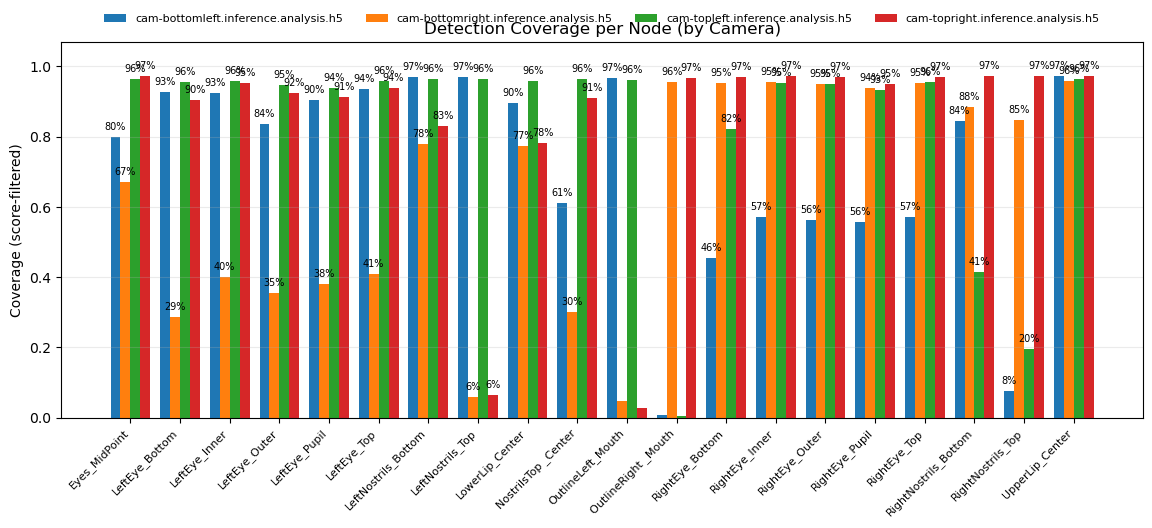

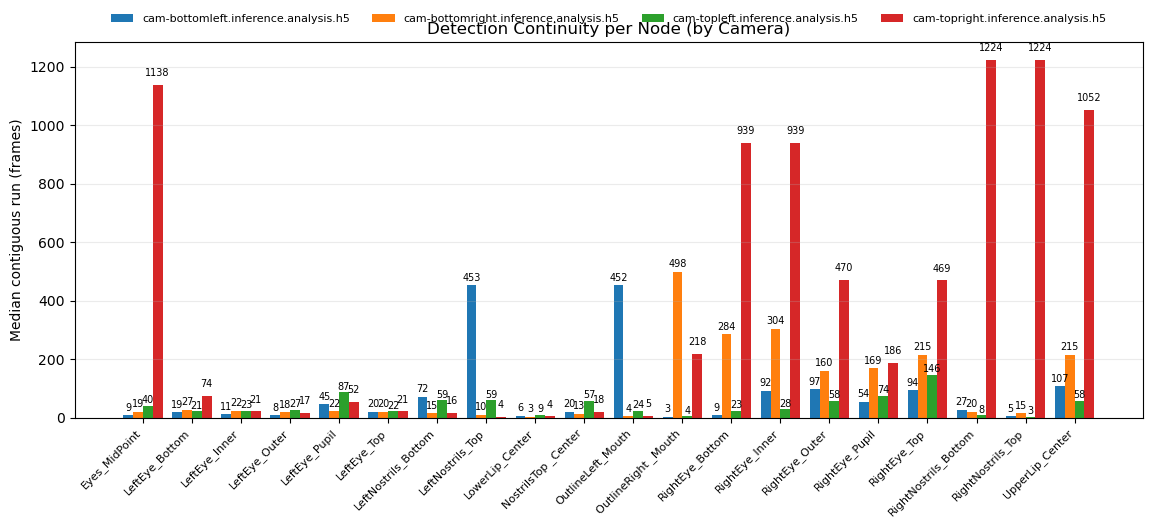

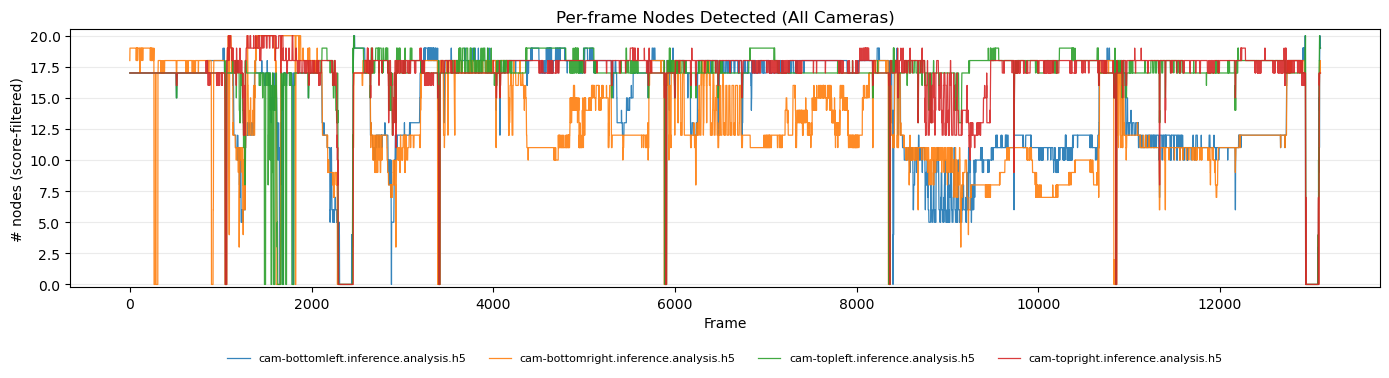

In [6]:
# m1 should still be the metrics_step1 folder from step 1
df_cov   = pd.read_csv(os.path.join(m1, "detection_coverage.csv"))
df_frame = pd.read_csv(os.path.join(m1, "per_frame_node_counts.csv"))

# =========================
# 1) COVERAGE BAR PLOT
# =========================
cov_thr = df_cov.pivot(index="node", columns="cam", values="coverage_thresh").sort_index()

nodes = cov_thr.index.to_list()
cams  = cov_thr.columns.to_list()

# make figure width scale with number of nodes so bars don't squeeze
fig_w = max(12, 0.6 * len(nodes))  # dynamically widen if many nodes
plt.figure(figsize=(fig_w, 6))

x = np.arange(len(nodes))
width = 0.8 / max(1, len(cams))  # bar thickness per camera

for i, cam in enumerate(cams):
    vals = cov_thr[cam].values  # values in [0,1]
    xpos = x + i*width
    bars = plt.bar(xpos, vals, width=width, label=cam)

    # annotate % only if bar is not tiny
    for xx, v in zip(xpos, vals):
        if v > 0.05:  # skip extremely tiny bars
            plt.text(
                xx,
                v + 0.015,
                f"{v*100:.0f}%",
                ha="center",
                va="bottom",
                fontsize=7,
                rotation=0
            )

# x labels: node names angled so they don't collide
plt.xticks(
    x + (len(cams)-1)*width/2,
    nodes,
    rotation=45,
    ha="right",
    fontsize=8
)

plt.ylim(0, 1.07)
plt.ylabel("Coverage (score-filtered)")
plt.title("Detection Coverage per Node (by Camera)")
plt.grid(axis="y", alpha=0.25)

# legend ABOVE plot so it doesn't overlap x labels
plt.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, 1.02),
    ncol=min(4, len(cams)),
    fontsize=8,
    frameon=False,
    borderaxespad=0.5
)

# reserve a little headroom for the legend
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.savefig(os.path.join(m1, "viz_coverage_thresholded_READABLE.png"), dpi=200)
plt.show()


# =========================
# 2) MEDIAN RUN LENGTH PLOT
# =========================
medrun = df_cov.pivot(index="node", columns="cam", values="median_run_thresh").sort_index()

nodes2 = medrun.index.to_list()
cams2  = medrun.columns.to_list()

fig_w2 = max(12, 0.6 * len(nodes2))
plt.figure(figsize=(fig_w2, 6))

x = np.arange(len(nodes2))
width = 0.8 / max(1, len(cams2))

for i, cam in enumerate(cams2):
    vals = medrun[cam].values  # median run length in frames
    xpos = x + i*width
    bars = plt.bar(xpos, vals, width=width, label=cam)

    # dynamic vertical offset so labels sit just above each bar
    y_off = max(2, 0.02 * np.nanmax(vals))
    for xx, v in zip(xpos, vals):
        if v > 0:  # skip zero bars
            plt.text(
                xx,
                v + y_off,
                f"{v:.0f}",
                ha="center",
                va="bottom",
                fontsize=7
            )

plt.xticks(
    x + (len(cams2)-1)*width/2,
    nodes2,
    rotation=45,
    ha="right",
    fontsize=8
)

plt.ylabel("Median contiguous run (frames)")
plt.title("Detection Continuity per Node (by Camera)")
plt.grid(axis="y", alpha=0.25)

plt.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, 1.02),
    ncol=min(4, len(cams2)),
    fontsize=8,
    frameon=False,
    borderaxespad=0.5
)

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.savefig(os.path.join(m1, "viz_median_run_length_READABLE.png"), dpi=200)
plt.show()


# =========================
# 3) PER-FRAME NODE COUNT TIMELINE
# =========================
plt.figure(figsize=(14, 4))
for cam, g in df_frame.groupby("cam"):
    plt.plot(
        g["frame"].values,
        g["nodes_detected_thresh"].values,
        linewidth=0.9,
        alpha=0.9,
        label=cam
    )

plt.xlabel("Frame")
plt.ylabel("# nodes (score-filtered)")
plt.title("Per-frame Nodes Detected (All Cameras)")
plt.ylim(
    -0.2,
    df_frame["nodes_detected_thresh"].max() + 0.5
)
plt.grid(axis="y", alpha=0.25)

plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.22),
    ncol=min(4, df_frame['cam'].nunique()),
    fontsize=8,
    frameon=False
)

plt.tight_layout()
plt.savefig(os.path.join(m1, "viz_nodes_per_frame_timeline_READABLE.png"), dpi=200)
plt.show()
